OPC UA Server:  opc.tcp://127.0.0.1:4840
Linearisierungskennlinie wird deaktiviert
False
Regler wird deaktiviert
Die aktuellen Signalfilter-Einstellungen lauten:
Signalfilter aktiv: False
Stat-Verhalten (IST) =  [[   0.       0.   ]
 [  10.       0.   ]
 [  20.      11.795]
 [  30.      19.054]
 [  40.      26.244]
 [  50.      34.86 ]
 [  60.      42.178]
 [  70.      48.635]
 [  80.      56.165]
 [  90.      62.309]
 [ 100.      70.646]]
Kennlinie =  [[  0.00000000e+00   0.00000000e+00]
 [  1.00000000e-03   1.00000000e+01]
 [  1.66959205e+01   2.00000000e+01]
 [  2.69710953e+01   3.00000000e+01]
 [  3.71486001e+01   4.00000000e+01]
 [  4.93446197e+01   5.00000000e+01]
 [  5.97033095e+01   6.00000000e+01]
 [  6.88432466e+01   7.00000000e+01]
 [  7.95020242e+01   8.00000000e+01]
 [  8.81989072e+01   9.00000000e+01]
 [  1.00000000e+02   1.00000000e+02]]
Stat-Verhalten (NEU) [[  0.00000000e+00  -9.10000000e-02]
 [  1.00000000e+01  -9.10000000e-02]
 [  2.00000000e+01   1.44990000e+01]
 [ 

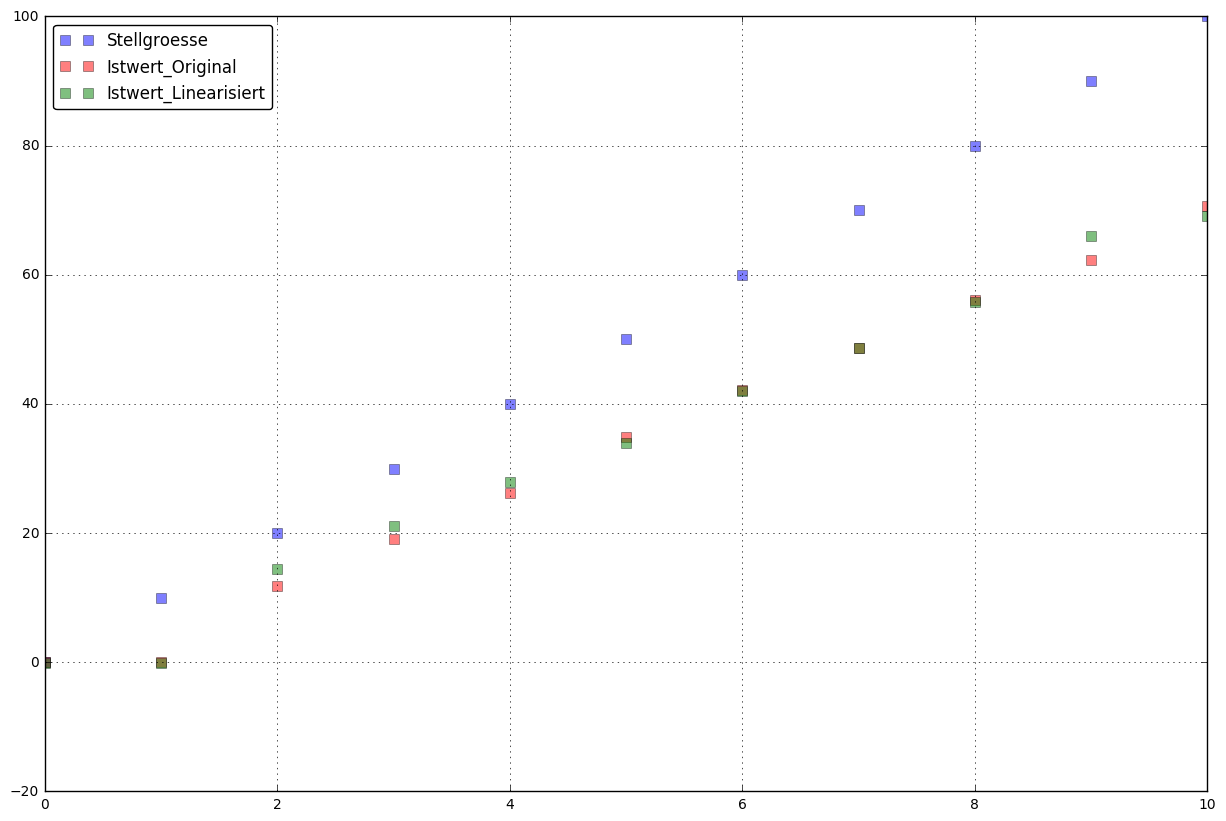

In [3]:
# Automatisierte Aufnahme stationäres Verhalten
# Funktionsumfang:
# - Stellgrösse manipulieren
# - Stationäres Verhalten aufzeichnen
#
# 2018-05-09, tr

import numpy as np
import matplotlib.pyplot as plt
import sys
from opcua import Client
from opcua import ua
from time import sleep
import csv


url = "opc.tcp://127.0.0.1:4840"
print('OPC UA Server: ', url)
client = Client(url)

# Parameter
StartAufnahme = True # Freigabe Aufnahme der Nicht-Linearitaet
bWrite2CodeSys = False # Freigabe Schreiben neue Kennlinie zur Linearisierung
TestLinearisierung = False # Freigabe Test der Linearisierung

# Aufnahme Stationäres Verhalten
StartWert = 0.0 # Startwert der Stellgroesse
StopWert = 100.0 # Endwert der Stellgroesse
divisor = 10.0 # Anzahl Schritte zwischen Start- und Endwert
timePerStep = 5 # Zeit mit stationaerem Stellwert
dY_dt = 2 # Rampensteilheit zwischen den einzelnen Schritten der Stellgroesse

txtFileName_1 = "Aufnahme_StatVerhalten_1_RS.txt"
txtFileName_2 = "Aufnahme_StatVerhalten_2_RS.txt"  

    
try:
    # Parameter:
    client.connect() 
    root = client.get_root_node()
    # Auslesen aktueller Parameter zur Linearisierung
    sps_eTyp_Y = root.get_child(["0:Objects", "2:DeviceSet", "4:CODESYS Control for Raspberry Pi SL", "4:Resources", "4:app", "3:Programs", "4:ACHSE", "4:signalgeno_Y", "4:eTyp"])
    sps_rY = root.get_child(["0:Objects", "2:DeviceSet", "4:CODESYS Control for Raspberry Pi SL", "4:Resources", "4:app", "3:Programs", "4:ACHSE", "4:signalgeno_Y", "4:rY"])
    sps_rY_offset = root.get_child(["0:Objects", "2:DeviceSet", "4:CODESYS Control for Raspberry Pi SL", "4:Resources", "4:app", "3:Programs", "4:ACHSE", "4:signalgeno_Y", "4:rOffset"])
    sps_rY_rampe = root.get_child(["0:Objects", "2:DeviceSet", "4:CODESYS Control for Raspberry Pi SL", "4:Resources", "4:app", "3:Programs", "4:ACHSE", "4:signalgeno_Y", "4:rRampe"])
    sps_rdY_dt = root.get_child(["0:Objects", "2:DeviceSet", "4:CODESYS Control for Raspberry Pi SL", "4:Resources", "4:app", "3:Programs", "4:ACHSE", "4:signalgeno_Y", "4:rdW_dt"])
    sps_rX = root.get_child(["0:Objects", "2:DeviceSet", "4:CODESYS Control for Raspberry Pi SL", "4:Resources", "4:app", "3:Programs", "4:ACHSE", "4:rX_Drehzahl"])
    sps_rY = root.get_child(["0:Objects", "2:DeviceSet", "4:CODESYS Control for Raspberry Pi SL", "4:Resources", "4:app", "3:Programs", "4:ACHSE", "4:rY_Drehzahl"])
    sps_rY_lin = root.get_child(["0:Objects", "2:DeviceSet", "4:CODESYS Control for Raspberry Pi SL", "4:Resources", "4:app", "3:Programs", "4:ACHSE", "4:rY_lin_Drehzahl"])
    sps_bLinAktiv = root.get_child(["0:Objects", "2:DeviceSet", "4:CODESYS Control for Raspberry Pi SL", "4:Resources", "4:app", "3:Programs", "4:ACHSE", "4:bLinDrehzahlAktiv"])
    
    # Signalfilter
    sps_bSignalFilterAktiv = root.get_child(["0:Objects", "2:DeviceSet", "4:CODESYS Control for Raspberry Pi SL", "4:Resources", "4:app", "3:Programs", "4:ACHSE", "4:bSignalfilterDrehzahlAktiv"])
    sps_rT = root.get_child(["0:Objects", "2:DeviceSet", "4:CODESYS Control for Raspberry Pi SL", "4:Resources", "4:app", "3:Programs", "4:ACHSE", "4:Signalfilter_Drehzahl", "4:rT"])
    
    # Regler
    sps_bReglerAktiv = root.get_child(["0:Objects", "2:DeviceSet", "4:CODESYS Control for Raspberry Pi SL", "4:Resources", "4:app", "3:Programs", "4:ACHSE", "4:bRE_DrehzahlAktiv"])
    # Vorsteuerung
    sps_bVorsteuerungAktiv = root.get_child(["0:Objects", "2:DeviceSet", "4:CODESYS Control for Raspberry Pi SL", "4:Resources", "4:app", "3:Programs", "4:ACHSE", "4:bVorsteuerungAktiv"])

    # Linearisierungskennlinie
    arXin_0 = root.get_child(["0:Objects", "2:DeviceSet", "4:CODESYS Control for Raspberry Pi SL", "4:Resources", "4:app", "3:Programs", "4:ACHSE", "4:linearisierung_Drehzahl", "4:arXin_0"])
    arXin_1 = root.get_child(["0:Objects", "2:DeviceSet", "4:CODESYS Control for Raspberry Pi SL", "4:Resources", "4:app", "3:Programs", "4:ACHSE", "4:linearisierung_Drehzahl", "4:arXin_1"])
    arXin_2 = root.get_child(["0:Objects", "2:DeviceSet", "4:CODESYS Control for Raspberry Pi SL", "4:Resources", "4:app", "3:Programs", "4:ACHSE", "4:linearisierung_Drehzahl", "4:arXin_2"])
    arXin_3 = root.get_child(["0:Objects", "2:DeviceSet", "4:CODESYS Control for Raspberry Pi SL", "4:Resources", "4:app", "3:Programs", "4:ACHSE", "4:linearisierung_Drehzahl", "4:arXin_3"])
    arXin_4 = root.get_child(["0:Objects", "2:DeviceSet", "4:CODESYS Control for Raspberry Pi SL", "4:Resources", "4:app", "3:Programs", "4:ACHSE", "4:linearisierung_Drehzahl", "4:arXin_4"])
    arXin_5 = root.get_child(["0:Objects", "2:DeviceSet", "4:CODESYS Control for Raspberry Pi SL", "4:Resources", "4:app", "3:Programs", "4:ACHSE", "4:linearisierung_Drehzahl", "4:arXin_5"])
    arXin_6 = root.get_child(["0:Objects", "2:DeviceSet", "4:CODESYS Control for Raspberry Pi SL", "4:Resources", "4:app", "3:Programs", "4:ACHSE", "4:linearisierung_Drehzahl", "4:arXin_6"])
    arXin_7 = root.get_child(["0:Objects", "2:DeviceSet", "4:CODESYS Control for Raspberry Pi SL", "4:Resources", "4:app", "3:Programs", "4:ACHSE", "4:linearisierung_Drehzahl", "4:arXin_7"])
    arXin_8 = root.get_child(["0:Objects", "2:DeviceSet", "4:CODESYS Control for Raspberry Pi SL", "4:Resources", "4:app", "3:Programs", "4:ACHSE", "4:linearisierung_Drehzahl", "4:arXin_8"])
    arXin_9 = root.get_child(["0:Objects", "2:DeviceSet", "4:CODESYS Control for Raspberry Pi SL", "4:Resources", "4:app", "3:Programs", "4:ACHSE", "4:linearisierung_Drehzahl", "4:arXin_9"])
    arXin_10 = root.get_child(["0:Objects", "2:DeviceSet", "4:CODESYS Control for Raspberry Pi SL", "4:Resources", "4:app", "3:Programs", "4:ACHSE", "4:linearisierung_Drehzahl", "4:arXin_10"])
    # Auslesen Stützpunkte Ausgangsvektor
    arYin_0 = root.get_child(["0:Objects", "2:DeviceSet", "4:CODESYS Control for Raspberry Pi SL", "4:Resources", "4:app", "3:Programs", "4:ACHSE", "4:linearisierung_Drehzahl", "4:arYin_0"])
    arYin_1 = root.get_child(["0:Objects", "2:DeviceSet", "4:CODESYS Control for Raspberry Pi SL", "4:Resources", "4:app", "3:Programs", "4:ACHSE", "4:linearisierung_Drehzahl", "4:arYin_1"])
    arYin_2 = root.get_child(["0:Objects", "2:DeviceSet", "4:CODESYS Control for Raspberry Pi SL", "4:Resources", "4:app", "3:Programs", "4:ACHSE", "4:linearisierung_Drehzahl", "4:arYin_2"])
    arYin_3 = root.get_child(["0:Objects", "2:DeviceSet", "4:CODESYS Control for Raspberry Pi SL", "4:Resources", "4:app", "3:Programs", "4:ACHSE", "4:linearisierung_Drehzahl", "4:arYin_3"])
    arYin_4 = root.get_child(["0:Objects", "2:DeviceSet", "4:CODESYS Control for Raspberry Pi SL", "4:Resources", "4:app", "3:Programs", "4:ACHSE", "4:linearisierung_Drehzahl", "4:arYin_4"])
    arYin_5 = root.get_child(["0:Objects", "2:DeviceSet", "4:CODESYS Control for Raspberry Pi SL", "4:Resources", "4:app", "3:Programs", "4:ACHSE", "4:linearisierung_Drehzahl", "4:arYin_5"])
    arYin_6 = root.get_child(["0:Objects", "2:DeviceSet", "4:CODESYS Control for Raspberry Pi SL", "4:Resources", "4:app", "3:Programs", "4:ACHSE", "4:linearisierung_Drehzahl", "4:arYin_6"])
    arYin_7 = root.get_child(["0:Objects", "2:DeviceSet", "4:CODESYS Control for Raspberry Pi SL", "4:Resources", "4:app", "3:Programs", "4:ACHSE", "4:linearisierung_Drehzahl", "4:arYin_7"])
    arYin_8 = root.get_child(["0:Objects", "2:DeviceSet", "4:CODESYS Control for Raspberry Pi SL", "4:Resources", "4:app", "3:Programs", "4:ACHSE", "4:linearisierung_Drehzahl", "4:arYin_8"])
    arYin_9 = root.get_child(["0:Objects", "2:DeviceSet", "4:CODESYS Control for Raspberry Pi SL", "4:Resources", "4:app", "3:Programs", "4:ACHSE", "4:linearisierung_Drehzahl", "4:arYin_9"])
    arYin_10 = root.get_child(["0:Objects", "2:DeviceSet", "4:CODESYS Control for Raspberry Pi SL", "4:Resources", "4:app", "3:Programs", "4:ACHSE", "4:linearisierung_Drehzahl", "4:arYin_10"])
    
    # Werte auslesen
    Signalgeneratortyp_old = sps_eTyp_Y.get_value()
    rY_old = round(sps_rY_rampe.get_value(),3)
    rX_old = round(sps_rX.get_value(),3)
    bLinAktiv = sps_bLinAktiv.get_value()
    bSignalFilterAktiv = sps_bSignalFilterAktiv.get_value()
    rT1_old = round(sps_rT.get_value(),3)
    bReglerAktiv = sps_bSignalFilterAktiv.get_value()
    
    # Signalgenerator ausschalten
    sps_eTyp_Y.set_value(ua.Variant(1, ua.VariantType.Int16))
    
    # Einstellungen für Aufnahme Linearität vorbereiten
    # 1. Linearisierungskennlinie ausschalten
    print('====================================================================')
    print('Linearisierungskennlinie wird deaktiviert')
    print(bLinAktiv)
    sps_bLinAktiv.set_value(ua.Variant(False, ua.VariantType.Boolean))
    
    # 2. Regler ausschalten
    print('====================================================================')
    print('Regler wird deaktiviert')
    sps_bReglerAktiv.set_value(ua.Variant(False, ua.VariantType.Boolean))

    # 3. Filterparameter richtig setzen
    print('Die aktuellen Signalfilter-Einstellungen lauten:')
    print('Signalfilter aktiv:', bSignalFilterAktiv)
    if bSignalFilterAktiv:
        print('Signalfilter T = ', rT1_old)
    print('====================================================================')
    
    StatVerhalten_1 = np.zeros((int(divisor+1),int(2))) # Array für ursprüngliches stationaeres Verhalten
    StatVerhalten_2 = np.zeros((int(divisor+1),int(2))) # Array für linearisiertes stationaeres Verhalten
    deltaStep = (StopWert-StartWert)/divisor
    
    # Signalgenerator mit y = 0 einschalten
    Signalgeneratortyp = 6 # enum 1: OFF, 2: OFFSET, 3: RECHTECK, 4: DREIECK, 5: SINUS, 6: RAMPE
    sps_rY_offset.set_value(ua.Variant(StartWert, ua.VariantType.Float))
    sps_rY_rampe.set_value(ua.Variant(StartWert, ua.VariantType.Float))
    sps_rdY_dt.set_value(ua.Variant(dY_dt, ua.VariantType.Float)) 
    # Start Aufnahme:
    sps_eTyp_Y.set_value(ua.Variant(1, ua.VariantType.Int16))
    
    #===========================================================================================
    if StartAufnahme:
        for i in range(int(divisor+1)):
            rY = float(i * deltaStep + StartWert)
            sps_rY_rampe.set_value(ua.Variant(rY, ua.VariantType.Float))
            sps_eTyp_Y.set_value(ua.Variant(Signalgeneratortyp, ua.VariantType.Int16))

            sleep(timePerStep)

            StatVerhalten_1[i,0] = round(sps_rY_rampe.get_value(),3)
            StatVerhalten_1[i,1] = max(0.0,round(sps_rX.get_value(),3)) # keine Winkel < 0°
            sleep(1.0)
        
        # Ende Aufnahme:
        Signalgeneratortyp = 1 # enum 1: OFF, 2: OFFSET, 3: RAMPE, 4: RECHTECK, 5: SINUS
        sps_eTyp_Y.set_value(ua.Variant(Signalgeneratortyp, ua.VariantType.Int16))
        sps_rY_rampe.set_value(ua.Variant(0.0, ua.VariantType.Float))
        sps_rY.set_value(ua.Variant(0.0, ua.VariantType.Float))
        
    else:
        # Datei einlesen
        anzSpalten = 2

        fileHandler = open(txtFileName_1, "r")
        anzZeilen = 0
        for line in fileHandler:    
            anzZeilen = anzZeilen + 1
        fileHandler.close()
        
        print(anzZeilen)
        
        values = np.ones((anzZeilen, anzSpalten))
        with open(txtFileName_1, newline='\n') as csvfile:
            spamreader = csv.reader(csvfile, delimiter='\t', quotechar='|')
            i = 0
            for zeile in spamreader:
                j = 0
                for j in range(anzSpalten):
                    StatVerhalten_1[i,j] = float(zeile[j])    
                i = i + 1
    
    print('Stat-Verhalten (IST) = ', StatVerhalten_1)
    
    #===========================================================================================
    # Stützwerte der Messung als Text-file abspeichern
    txtFile = open(txtFileName_1, 'w')
    for i in range(int(divisor+1)):
        line = ''
        line = '{:.3f}\t'.format(StatVerhalten_1[i,0])
        line = line + '{:.3f}\t'.format(StatVerhalten_1[i,1])
        txtFile.write(line + '\n')
    txtFile.close()    
    
    #===========================================================================================
    # Linearisierung berechnen
    Input = StatVerhalten_1[:,0]
    Output = StatVerhalten_1[:,1]
    
    AnzWerte = len(Input)
    
    input_max = max(Input)
    output_max = max(Output)
    # Normalisiert mit StopWert, dadurch wird maximaler Stellwert nicht überschritten
    input_pu = Input/input_max * StopWert
    output_pu = Output/output_max * StopWert
    
    kennlinie = np.zeros((AnzWerte, 2))
    ActInput = min(Input) - 1000
    
    for i in range(AnzWerte):
        if output_pu[i] > ActInput:
            kennlinie[i,0] = output_pu[i]    
            kennlinie[i,1] = input_pu[i]
            ActInput = kennlinie[i,0]
        else:
            kennlinie[i,0] = output_pu[i] + i/1000 
            kennlinie[i,1] = input_pu[i]
            ActInput = kennlinie[i,0]
            
    print('Kennlinie = ', kennlinie)
    #===========================================================================================
    if bWrite2CodeSys:
        # Stützpunkte Eingangsvektor
        arXin_0.set_value(ua.Variant(kennlinie[0,0], ua.VariantType.Float))
        arXin_1.set_value(ua.Variant(kennlinie[1,0], ua.VariantType.Float))
        arXin_2.set_value(ua.Variant(kennlinie[2,0], ua.VariantType.Float))
        arXin_3.set_value(ua.Variant(kennlinie[3,0], ua.VariantType.Float))
        arXin_4.set_value(ua.Variant(kennlinie[4,0], ua.VariantType.Float))
        arXin_5.set_value(ua.Variant(kennlinie[5,0], ua.VariantType.Float))
        arXin_6.set_value(ua.Variant(kennlinie[6,0], ua.VariantType.Float))
        arXin_7.set_value(ua.Variant(kennlinie[7,0], ua.VariantType.Float))
        arXin_8.set_value(ua.Variant(kennlinie[8,0], ua.VariantType.Float))
        arXin_9.set_value(ua.Variant(kennlinie[9,0], ua.VariantType.Float))
        arXin_10.set_value(ua.Variant(kennlinie[10,0], ua.VariantType.Float))
        # Stützpunkte Ausgangsvektor
        arYin_0.set_value(ua.Variant(kennlinie[0,1], ua.VariantType.Float))
        arYin_1.set_value(ua.Variant(kennlinie[1,1], ua.VariantType.Float))
        arYin_2.set_value(ua.Variant(kennlinie[2,1], ua.VariantType.Float))
        arYin_3.set_value(ua.Variant(kennlinie[3,1], ua.VariantType.Float))
        arYin_4.set_value(ua.Variant(kennlinie[4,1], ua.VariantType.Float))
        arYin_5.set_value(ua.Variant(kennlinie[5,1], ua.VariantType.Float))
        arYin_6.set_value(ua.Variant(kennlinie[6,1], ua.VariantType.Float))
        arYin_7.set_value(ua.Variant(kennlinie[7,1], ua.VariantType.Float))
        arYin_8.set_value(ua.Variant(kennlinie[8,1], ua.VariantType.Float))
        arYin_9.set_value(ua.Variant(kennlinie[9,1], ua.VariantType.Float))
        arYin_10.set_value(ua.Variant(kennlinie[10,1], ua.VariantType.Float))
        # Linearisierungskennlinie aktivieren
        sps_bLinAktiv.set_value(ua.Variant(True, ua.VariantType.Boolean))
        
    #===========================================================================================
    # Start Ueberpruefung der Linearisierung
    # Signalgenerator ausschalten
    sps_eTyp_Y.set_value(ua.Variant(1, ua.VariantType.Int16))
    # Signalgenerator mit y = 0 einschalten
    if TestLinearisierung:
        Signalgeneratortyp = 6 # enum 1: OFF, 2: OFFSET, 3: RECHTECK, 4: DREIECK, 5: SINUS, 6: RAMPE
        sps_rY.set_value(ua.Variant(0.0, ua.VariantType.Float))
        sps_rY_offset.set_value(ua.Variant(0.0, ua.VariantType.Float))
        sps_eTyp_Y.set_value(ua.Variant(Signalgeneratortyp, ua.VariantType.Int16))
        sps_rY_rampe.set_value(ua.Variant(0.0, ua.VariantType.Float))

        for i in range(int(divisor+1)):
            rY = float(i * deltaStep + StartWert)
            sps_rY_rampe.set_value(ua.Variant(rY, ua.VariantType.Float))
            sps_eTyp_Y.set_value(ua.Variant(Signalgeneratortyp, ua.VariantType.Int16))

            sleep(timePerStep)

            StatVerhalten_2[i,0] = round(sps_rY_rampe.get_value(),3)
            StatVerhalten_2[i,1] = round(sps_rX.get_value(),3)
            sleep(1.0)

        # Ende Aufnahme:
        Signalgeneratortyp = 1 # enum 1: OFF, 2: OFFSET, 3: RAMPE, 4: RECHTECK, 5: SINUS
        sps_eTyp_Y.set_value(ua.Variant(Signalgeneratortyp, ua.VariantType.Int16))
        sps_rY_rampe.set_value(ua.Variant(0.0, ua.VariantType.Float))
        sps_rY.set_value(ua.Variant(0.0, ua.VariantType.Float))
    
    print('Stat-Verhalten (NEU)', StatVerhalten_2)
    
    #===========================================================================================
    # Stützwerte der Messung als Text-file abspeichern
    txtFile = open(txtFileName_2, 'w')
    for i in range(int(divisor+1)):
        line = ''
        line = '{:.3f}\t'.format(StatVerhalten_2[i,0])
        line = line + '{:.3f}\t'.format(StatVerhalten_2[i,1])
        txtFile.write(line + '\n')
    txtFile.close()  
    
    #===========================================================================================
    # Plot
    fig1 = plt.figure(figsize=(15.0, 10.0), dpi=300, facecolor="white")
    ax = fig1.add_subplot(1,1,1)    
    ax.plot(StatVerhalten_1[:,0], 'bs', markersize=7, alpha=0.5, label="Stellgroesse")
    ax.plot(StatVerhalten_1[:,1], 'rs', markersize=7, alpha=0.5, label="Istwert_Original")
    ax.plot(StatVerhalten_2[:,1], 'gs', markersize=7, alpha=0.5, label="Istwert_Linearisiert")
    
    ax.legend(loc='upper left', fancybox=True, title='')         
    plt.grid(True)
    plt.show() 
    fig1.savefig('StatVerhalten.png', dpi=300)
   
except:
    print('Error OPC UA open read write:', sys.exc_info()[0])

finally:
    try:
        client.disconnect()

    except:
        print('Error OPC UA disconnect', sys.exc_info()[0])

* [StatVerhalten.png](StatVerhalten.png)
* [Aufnahme_StatVerhalten_1_Druckdiff_RS.txt](Aufnahme_StatVerhalten_1_Druckdiff_RS.txt)
* [Aufnahme_StatVerhalten_2_Druckdiff_RS.txt](Aufnahme_StatVerhalten_2_Druckdiff_RS.txt)